In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from causalml.match import NearestNeighborMatch
#this is all gifted students!
df = pd.read_csv("../data/boundary.csv")
df.drop(columns=['Unnamed: 0'],inplace=True)
masterbuild = pd.read_csv("../data/masterbuild_master.csv")
masterbuild = masterbuild[['mastid','lea']]

df = df.merge(masterbuild, on='mastid',how='left')
# Step 1: Convert LEA to string and keep only numeric ones
df = df[df['lea'].astype(str).str.match(r'^\d+$')].copy()

# Step 2: Drop students who ever appear in more than one LEA
lea_counts_per_student = df.groupby('mastid')['lea'].nunique()
stable_mastids = lea_counts_per_student[lea_counts_per_student == 1].index

df = df[df['mastid'].isin(stable_mastids)].copy()
df.drop_duplicates(inplace=True, keep='first')
#add asian
ethnic_cols = ['ethnic_W', 'ethnic_B', 'ethnic_H', 'ethnic_I', 'ethnic_M', 'ethnic_P']
df['ethnic_A'] = (df[ethnic_cols].sum(axis=1) == 0).astype(bool)


/var/folders/dk/2mw0y5w91dggrsnrpxb04jv80000gn/T/ipykernel_14810/1894640756.py:8: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  masterbuild = pd.read_csv("../data/masterbuild_master.csv")


Doing propensity score matching to match students who are similarly likely to be labeled as gifted. Additionally, we use a similarity score caliper to make sure that these propensity score matches are also similar demographically (i.e., similarly likely to be gifted AND both a certain ethnicity or both economically disadvantaged or both boys/girls)

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

gifted_grades = list(range(4, 9))
matched_dfs = []
match_id_counter = 0
caliper = 0.05

# Filter districts with digit-only IDs
df = df[df['lea'].astype(str).str.match(r'^\d+$')].copy()

for grade in gifted_grades:
    print(f"\nProcessing grade {grade}...")

    treated_all = df[df['gifted_grade'] == grade].copy()
    controls_all = df[df['gifted_grade'] == 0].copy()

    if treated_all.empty:
        print(f"  Skipping grade {grade}: no treated units.")
        continue

    for lea in treated_all['lea'].unique():
        treated = treated_all[treated_all['lea'] == lea].copy()
        controls = controls_all[controls_all['lea'] == lea].copy()

        if treated.empty or controls.empty:
            continue

        sub_df = pd.concat([treated, controls], axis=0).copy()
        sub_df['treatment'] = (sub_df['gifted_grade'] == grade).astype(int)

        test_cols = [col for col in sub_df.columns if col.startswith(('math_', 'reading_'))]
        pre_cols = [col for col in test_cols if int(col.split('_')[1]) < grade]
        dummy_cols = [col for col in sub_df.columns if col.startswith(('sex_', 'ethnic_', 'eds_'))]
        covariates = pre_cols + dummy_cols

        sub_df_clean = sub_df.dropna(subset=covariates, how='any').reset_index(drop=True)

        math_cols = [col for col in pre_cols if col.startswith('math_')]
        reading_cols = [col for col in pre_cols if col.startswith('reading_')]

        treated_df = sub_df_clean[sub_df_clean['treatment'] == 1]
        if treated_df.empty:
            continue

        math_min = treated_df[math_cols].min().min()
        reading_min = treated_df[reading_cols].min().min()

        sub_df_clean = sub_df_clean[
            sub_df_clean[math_cols].ge(math_min).all(axis=1) &
            sub_df_clean[reading_cols].ge(reading_min).all(axis=1)
        ]

        if sub_df_clean['treatment'].sum() == 0 or sub_df_clean['treatment'].sum() == len(sub_df_clean):
            continue

        # Prepare covariate matrix
        X = sub_df_clean[covariates].copy()
        for col in X.select_dtypes(exclude='number').columns:
            if X[col].dtype == 'bool':
                X[col] = X[col].astype(int)
            elif X[col].dtype == 'object':
                X[col] = X[col].map({'True': 1, 'False': 0, True: 1, False: 0})
        X = X.fillna(0)

        # Standardize covariates
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Estimate propensity scores
        ps_model = LogisticRegression(max_iter=5000)
        ps_model.fit(X_scaled, sub_df_clean['treatment'])
        sub_df_clean['pscore'] = ps_model.predict_proba(X_scaled)[:, 1]

        # Track row alignment
        row_index_map = dict(zip(sub_df_clean.index, range(len(sub_df_clean))))

        treated = sub_df_clean[sub_df_clean['treatment'] == 1].copy()
        controls = sub_df_clean[sub_df_clean['treatment'] == 0].copy()

        matched_pairs = []

        for idx_t in treated.index:
            pscore_t = sub_df_clean.at[idx_t, 'pscore']
            pool = controls[np.abs(controls['pscore'] - pscore_t) <= caliper]

            if pool.empty:
                continue

            X_t = X_scaled[row_index_map[idx_t]].reshape(1, -1)
            X_pool = X_scaled[[row_index_map[i] for i in pool.index]]

            nn = NearestNeighbors(n_neighbors=1)
            nn.fit(X_pool)
            _, nn_idx = nn.kneighbors(X_t)

            matched_idx = pool.index[nn_idx[0][0]]
            matched_pairs.append((idx_t, matched_idx))

        if not matched_pairs:
            continue

        match_ids = range(match_id_counter, match_id_counter + len(matched_pairs))
        match_id_counter += len(matched_pairs)

        treated_matches = sub_df_clean.loc[[i for i, _ in matched_pairs]].copy()
        control_matches = sub_df_clean.loc[[j for _, j in matched_pairs]].copy()

        treated_matches['match_id'] = match_ids
        control_matches['match_id'] = match_ids

        matched_result = pd.concat([treated_matches, control_matches])
        matched_result['match_grade'] = grade
        if matched_result['match_id'].nunique() < 100:
            print(f"  Skipping Grade {grade} | LEA {lea}: too few matched pairs ({matched_result['match_id'].nunique()})")
            continue

        matched_dfs.append(matched_result)

        print(f"  Grade {grade} | LEA {lea} | Matches: {len(matched_result)}")

# Final combined match set
all_matches = pd.concat(matched_dfs, axis=0).reset_index(drop=True)


all_matches_trimmed = all_matches[(all_matches['pscore'] >= 0.25) & (all_matches['pscore'] <= 0.75)]



Processing grade 4...
  Grade 4 | LEA 970 | Matches: 618
  Grade 4 | LEA 491 | Matches: 946
  Grade 4 | LEA 020 | Matches: 748
  Grade 4 | LEA 990 | Matches: 824
  Grade 4 | LEA 190 | Matches: 1356
  Skipping Grade 4 | LEA 862: too few matched pairs (80)
  Grade 4 | LEA 790 | Matches: 1986
  Grade 4 | LEA 680 | Matches: 542
  Grade 4 | LEA 410 | Matches: 2954
  Grade 4 | LEA 900 | Matches: 6136
  Grade 4 | LEA 290 | Matches: 2080
  Grade 4 | LEA 850 | Matches: 824
  Grade 4 | LEA 490 | Matches: 1546
  Grade 4 | LEA 340 | Matches: 964
  Grade 4 | LEA 111 | Matches: 264
  Grade 4 | LEA 110 | Matches: 896
  Grade 4 | LEA 060 | Matches: 218
  Grade 4 | LEA 590 | Matches: 562
  Grade 4 | LEA 450 | Matches: 720
  Grade 4 | LEA 600 | Matches: 3412
  Grade 4 | LEA 440 | Matches: 306
  Skipping Grade 4 | LEA 030: too few matched pairs (59)
  Grade 4 | LEA 230 | Matches: 1154
  Grade 4 | LEA 760 | Matches: 1232
  Grade 4 | LEA 300 | Matches: 1060
  Grade 4 | LEA 620 | Matches: 264
  Grade 4 | L

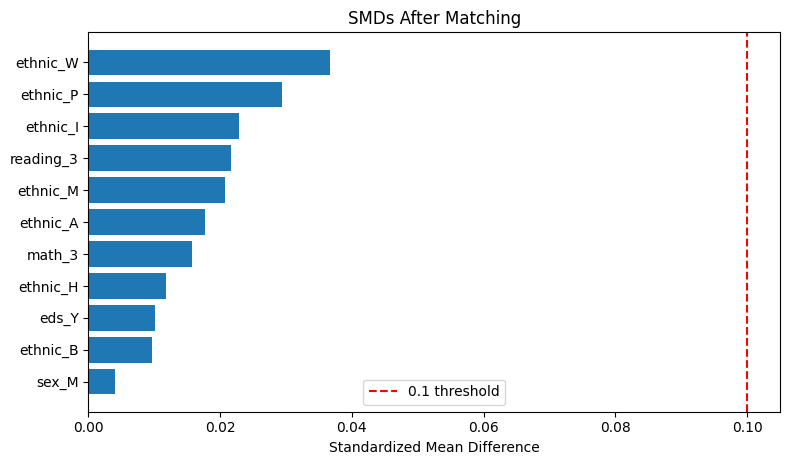

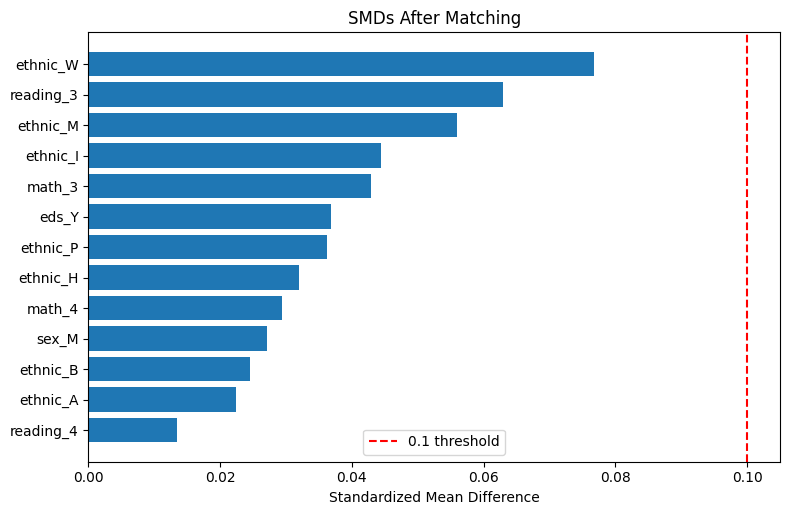

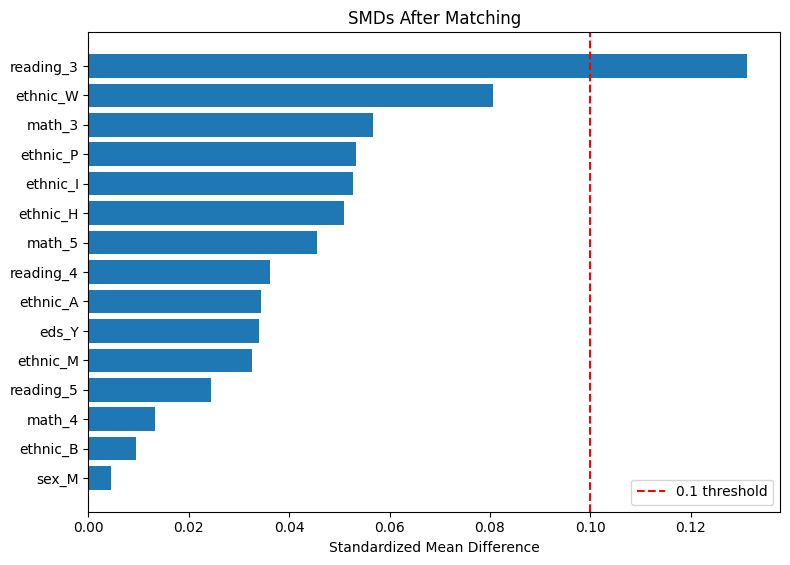

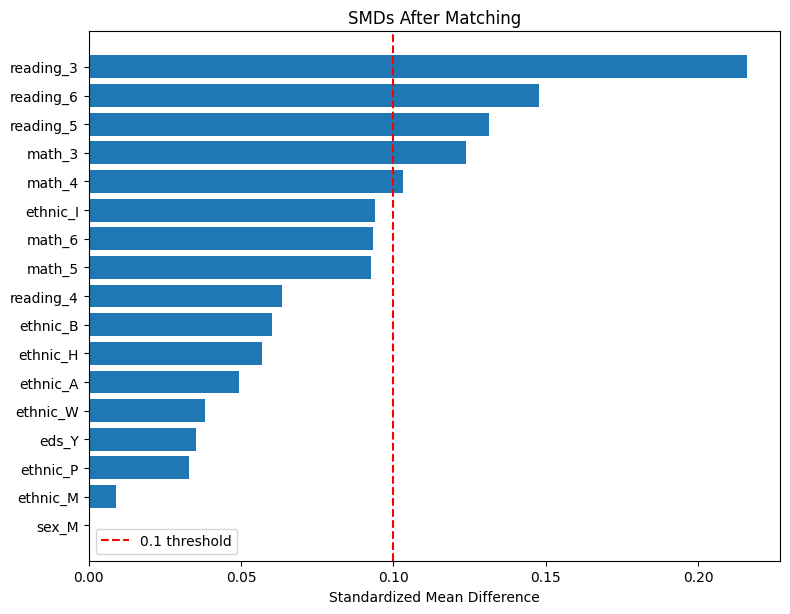

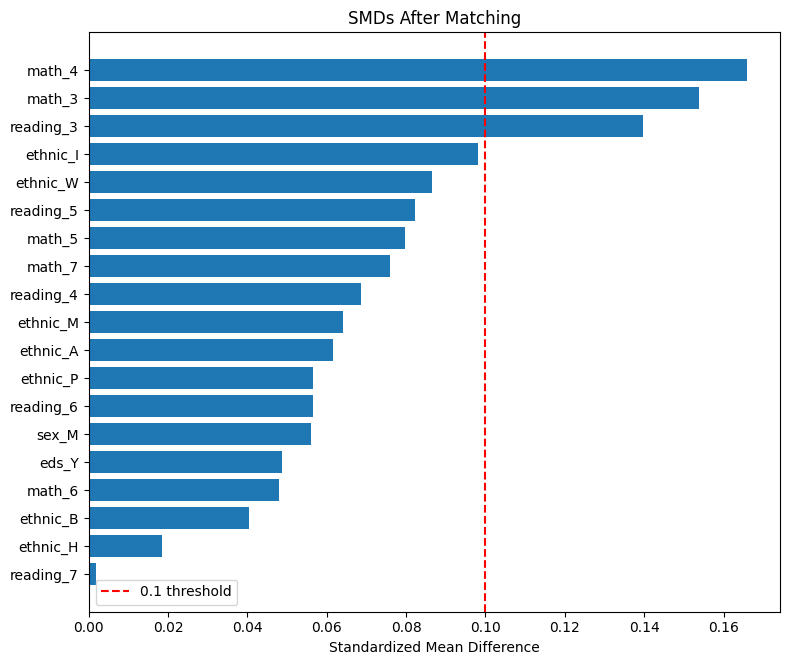

In [44]:
#SMDs hidden
import matplotlib.pyplot as plt
import numpy as np

grades = all_matches_trimmed['match_grade'].unique()
for grade in sorted(grades):
    df_grade = all_matches_trimmed[all_matches_trimmed['match_grade'] == grade]

    treated = df_grade[df_grade['treatment'] == 1]
    control = df_grade[df_grade['treatment'] == 0]

    # Only use pre-treatment test scores
    test_covs = [col for col in df_grade.columns if col.startswith(('math_', 'reading_')) and int(col.split('_')[1]) < grade]
    static_covs = [col for col in df_grade.columns if col.startswith(('sex_', 'ethnic_', 'eds_'))]
    covariates = test_covs + static_covs

    smd_values = []
    cov_names = []

    for cov in covariates:
        m1 = treated[cov].mean()
        m0 = control[cov].mean()
        s1 = treated[cov].std()
        s0 = control[cov].std()
        denom = np.sqrt((s1**2 + s0**2) / 2)
        smd = abs(m1 - m0) / denom if denom != 0 else 0
        smd_values.append(smd)
        cov_names.append(cov)

    if not smd_values:
        continue

    sorted_pairs = sorted(zip(cov_names, smd_values), key=lambda x: x[1], reverse=True)
    sorted_covs, sorted_smds = zip(*sorted_pairs)

    plt.figure(figsize=(8, len(sorted_covs) * 0.25 + 2))
    plt.barh(sorted_covs, sorted_smds)
    plt.axvline(0.1, color='red', linestyle='--', label='0.1 threshold')
    plt.title(f'SMDs After Matching')
    plt.xlabel('Standardized Mean Difference')
    plt.gca().invert_yaxis()
    plt.legend()
    plt.tight_layout()
    #plt.show()
    #IF YOU WANT TO SEE SMDs
    


Moral of the story is that it's mostly balanced, but there are more white people, more not-disadvantaged students, and more students who test better early on

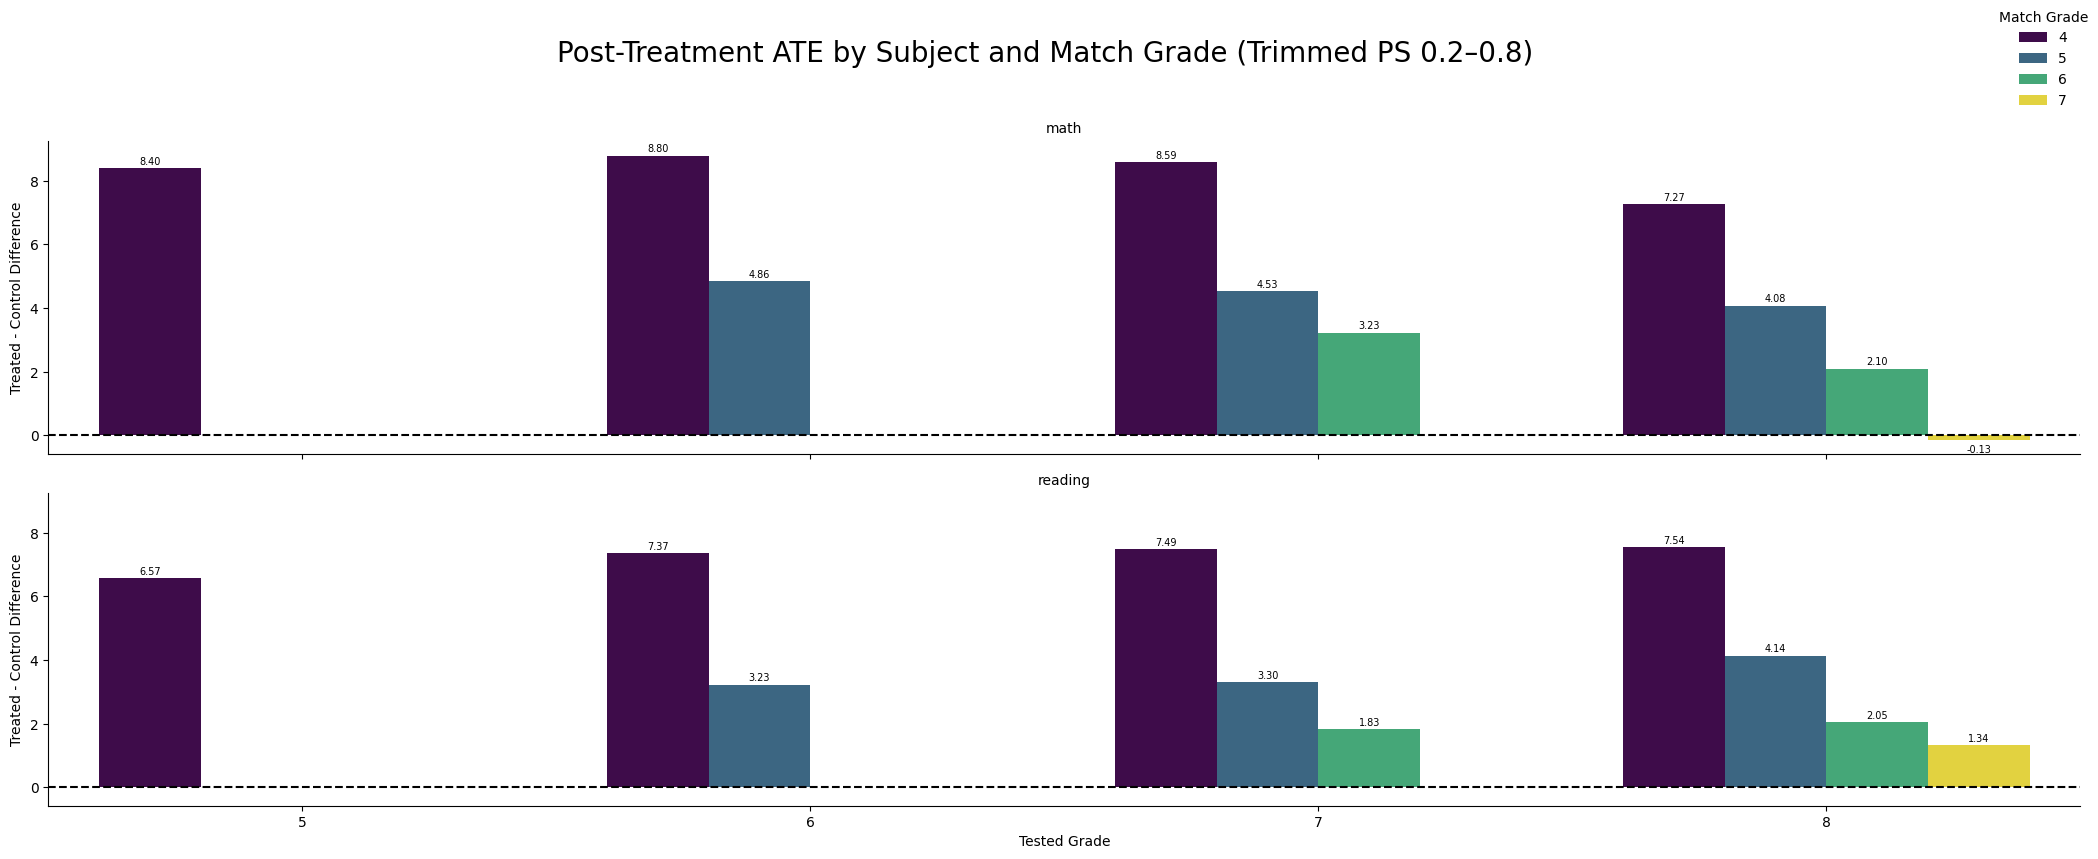

In [45]:
#ATEs by grade
from scipy.stats import ttest_ind
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

gifted_grades = list(range(4, 9))  # Grades 4–8
post_effects_trimmed = []

# Loop through each match grade cohort
for grade in gifted_grades:
    df_g = all_matches_trimmed[all_matches_trimmed['match_grade'] == grade].copy()
    if df_g.empty:
        continue

    test_cols = [col for col in df_g.columns if col.startswith(('math_', 'reading_'))]
    post_cols = [col for col in test_cols if int(col.split('_')[1]) > grade]

    for col in sorted(post_cols, key=lambda x: int(x.split('_')[1])):
        means = df_g.groupby('treatment')[col].mean()
        n = df_g.groupby('treatment')[col].count()

        tstat, pval = ttest_ind(
            df_g[df_g['treatment'] == 1][col],
            df_g[df_g['treatment'] == 0][col],
            nan_policy='omit'
        )

        post_effects_trimmed.append({
            'match_grade': grade,
            'score_col': col,
            'treated_mean': means.get(1, float('nan')),
            'control_mean': means.get(0, float('nan')),
            'difference': means.get(1, float('nan')) - means.get(0, float('nan')),
            'treated_n': n.get(1, 0),
            'control_n': n.get(0, 0),
            'p_value': pval
        })

# Create a summary DataFrame
effects_trimmed_df = pd.DataFrame(post_effects_trimmed)
effects_trimmed_df = effects_trimmed_df.sort_values(by=['match_grade', 'score_col'])

# Extract subject and grade from score_col for plotting
effects_trimmed_df['subject'] = effects_trimmed_df['score_col'].apply(lambda x: x.split('_')[0])
effects_trimmed_df['score_grade'] = effects_trimmed_df['score_col'].apply(lambda x: int(x.split('_')[1]))



import matplotlib.pyplot as plt
import seaborn as sns

# Make a copy to work with
viz_df = effects_trimmed_df.copy()

# Initialize FacetGrid with vertical layout
g = sns.FacetGrid(
    viz_df,
    row="subject",
    sharey=True,
    height=4,
    aspect=5
)

# Draw grouped bars in each facet
g.map_dataframe(
    sns.barplot,
    x='score_grade',
    y='difference',
    hue='match_grade',
    palette='viridis',
    dodge=True
)

# Add horizontal line and annotations
for ax in g.axes.flat:
    ax.axhline(0, color='black', linestyle='--')
    for container in ax.containers:
        for bar in container:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + (0.05 if height >= 0 else -0.15),
                f'{height:.2f}',
                ha='center',
                va='bottom' if height >= 0 else 'top',
                fontsize=7
            )

# Clean up plot
g.set_titles("{row_name}")
g.set_axis_labels("Tested Grade", "Treated - Control Difference")
g.add_legend(title="Match Grade")
g._legend.set_bbox_to_anchor((1, 1))


plt.suptitle("Post-Treatment ATE by Subject and Match Grade (Trimmed PS 0.2–0.8)", fontsize=20, y=1.03)
plt.tight_layout()
plt.show()



Math ATE goes down over time, reading ATE goes up, and the biggest treatment effects are associated with the students who are gifted the earliest.

In [46]:
import numpy as np
import pandas as pd
import scipy.stats as stats

# Start with the trimmed matched data
df = all_matches[(all_matches['pscore'] >= 0.2) & (all_matches['pscore'] <= 0.8)].copy()

did_results = []

for subject in ['math', 'reading']:
    pre = f'{subject}_3'
    post = f'{subject}_8'

    if pre not in df.columns or post not in df.columns:
        continue

    df = df.copy()
    df['change'] = df[post] - df[pre]

    treated = df[df['treatment'] == 1]['change']
    control = df[df['treatment'] == 0]['change']

    diff_treated = treated.mean()
    diff_control = control.mean()
    did = diff_treated - diff_control

    # Sample sizes
    n_treated = treated.count()
    n_control = control.count()

    # Standard deviations
    std_treated = treated.std(ddof=1)
    std_control = control.std(ddof=1)

    # Pooled standard deviation
    pooled_std = np.sqrt(((n_treated - 1)*std_treated**2 + (n_control - 1)*std_control**2) / (n_treated + n_control - 2))

    # Cohen's d
    cohen_d = did / pooled_std

    # Standard error of the difference in means
    se_diff = np.sqrt((std_treated**2 / n_treated) + (std_control**2 / n_control))

    # 95% confidence interval
    t_crit = stats.t.ppf(0.975, df=n_treated + n_control - 2)
    ci_low = did - t_crit * se_diff
    ci_high = did + t_crit * se_diff

    did_results.append({
        'subject': subject,
        'treated_mean_change': diff_treated,
        'control_mean_change': diff_control,
        'difference_in_difference': did,
        'treated_n': n_treated,
        "Cohen's D": cohen_d,
        "CI Lower": ci_low,
        "CI upper": ci_high
    })

did_df = pd.DataFrame(did_results)
did_df


,subject,treated_mean_change,control_mean_change,difference_in_difference,treated_n,Cohen's D,CI Lower,CI upper
0,math,-3.385573,-9.446947,6.061374,43416,0.357795,5.836106,6.286641
1,reading,-3.845545,-10.733508,6.887964,43416,0.395825,6.656565,7.119363


In [47]:
# Group by treatment and compute mean math and reading scores at grade 3
baseline_means = all_matches_trimmed.groupby('treatment')[['math_3', 'reading_3']].mean().round(2)
baseline_means.index = baseline_means.index.map({0: 'Control', 1: 'Treated'})
baseline_means


,math_3,reading_3
treatment,,
Control,86.78,85.36
Treated,86.65,84.84


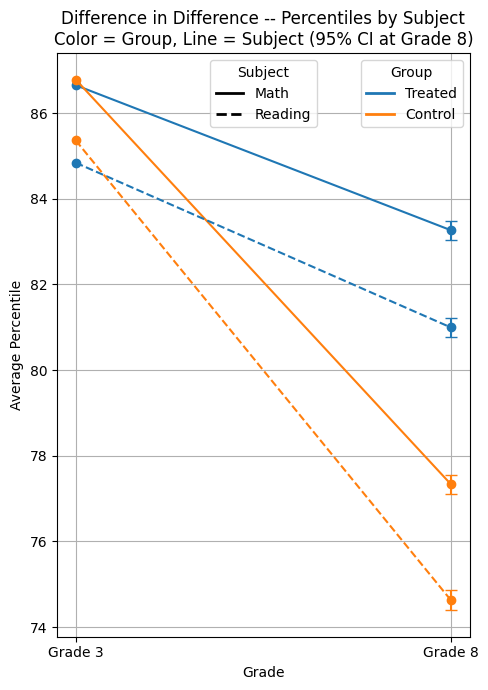

In [48]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Reshape baseline_means for merging
baseline_long = baseline_means.reset_index().melt(id_vars='treatment', var_name='subject', value_name='baseline')
baseline_long['subject'] = baseline_long['subject'].str.replace('_3', '')  # clean subject names

# Pivot to wide format to get treated_pre and control_pre
baseline_wide = baseline_long.pivot(index='subject', columns='treatment', values='baseline').reset_index()
baseline_wide.columns.name = None
baseline_wide = baseline_wide.rename(columns={
    'Treated': 'treated_pre',
    'Control': 'control_pre'
})

# Merge with did_df
plot_df = pd.merge(did_df, baseline_wide, on='subject')

# Compute post-treatment scores
plot_df['treated_post'] = plot_df['treated_pre'] + plot_df['treated_mean_change']
plot_df['control_post'] = plot_df['control_pre'] + plot_df['control_mean_change']

# Plotting
grades = ['Grade 3', 'Grade 8']
colors = {'Treated': 'tab:blue', 'Control': 'tab:orange'}
linestyles = {'math': '-', 'reading': '--'}

fig, ax = plt.subplots(figsize=(5, 7))

for _, row in plot_df.iterrows():
    subject = row['subject']

    treated_y = [row['treated_pre'], row['treated_post']]
    control_y = [row['control_pre'], row['control_post']]

    ax.plot(grades, treated_y, color=colors['Treated'], linestyle=linestyles[subject], marker='o')
    ax.plot(grades, control_y, color=colors['Control'], linestyle=linestyles[subject], marker='o')

    # CI at Grade 8
    ci_half = (row['CI upper'] - row['CI Lower']) / 2
    ax.errorbar(grades[1], row['treated_post'], yerr=ci_half, fmt='none', ecolor=colors['Treated'], capsize=4, lw=1.5)
    ax.errorbar(grades[1], row['control_post'], yerr=ci_half, fmt='none', ecolor=colors['Control'], capsize=4, lw=1.5)

# Legends
group_handles = [
    Line2D([0], [0], color=colors['Treated'], lw=2, label='Treated'),
    Line2D([0], [0], color=colors['Control'], lw=2, label='Control')
]
subject_handles = [
    Line2D([0], [0], color='black', linestyle='-', lw=2, label='Math'),
    Line2D([0], [0], color='black', linestyle='--', lw=2, label='Reading')
]
legend1 = ax.legend(handles=group_handles, title='Group', loc='upper right')
legend2 = ax.legend(handles=subject_handles, title='Subject', loc='upper center')
ax.add_artist(legend1)

# Final touches
ax.set_title('Difference in Difference -- Percentiles by Subject\nColor = Group, Line = Subject (95% CI at Grade 8)')
ax.set_ylabel('Average Percentile')
ax.set_xlabel('Grade')
ax.grid(True)
plt.tight_layout()
plt.show()


All of these students regress based on standardized test percentile. Perhaps this is regression to the mean after one outlier year that got them the gifted tag. The gifted students fall much less than the nongifted students

“Among students matched on test scores and demographics, those placed in gifted programs showed over 6-point gains in both math and reading by 8th grade, compared to their matched peers. These gains hold even after accounting for where students started in 3rd grade — suggesting a substantial and persistent benefit from gifted placement.”
Difference in difference accounts for the idea that gifted students might start with higher test scores (although they shouldn't because they aren't labeled gifted in 3rd grade) -- it only tracks the progress they make

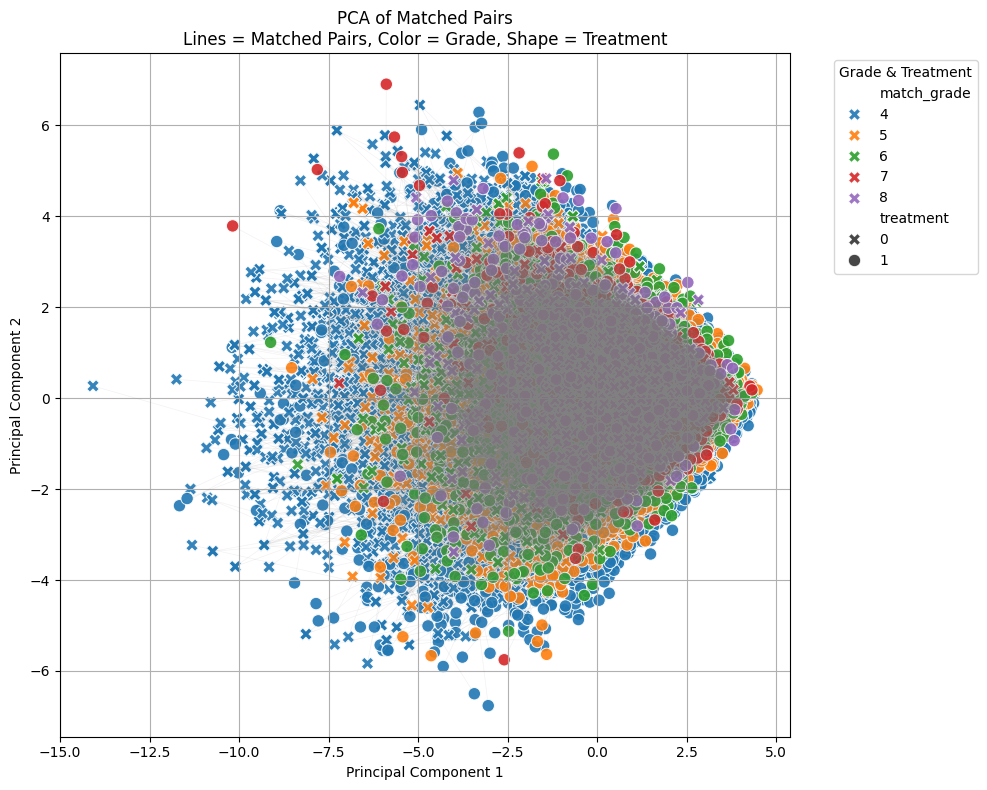

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Step 1: Select numeric data (excluding treatment & match_grade)
numeric_data = all_matches_trimmed.select_dtypes(include='number').drop(columns=['treatment', 'match_grade'], errors='ignore')

# Step 2: Standardize
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

# Step 3: PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Step 4: Add PCA results back
plot_df = all_matches_trimmed[['match_id', 'treatment', 'match_grade']].copy()
plot_df['PC1'] = pca_result[:, 0]
plot_df['PC2'] = pca_result[:, 1]

# Step 5: Keep only matched pairs (match_id appears exactly twice)
valid_pairs = plot_df['match_id'].value_counts()
valid_pairs = valid_pairs[valid_pairs == 2].index
plot_df = plot_df[plot_df['match_id'].isin(valid_pairs)]

# Step 6: Plot
plt.figure(figsize=(10, 8))

# Draw lines between matched pairs
for _, group in plot_df.groupby('match_id'):
    if len(group) == 2:
        x_vals = group['PC1'].values
        y_vals = group['PC2'].values
        plt.plot(x_vals, y_vals, color='gray', linestyle='-', linewidth=0.5, alpha=0.1)

# Scatter plot: style by treatment, color by match_grade
sns.scatterplot(
    data=plot_df,
    x='PC1',
    y='PC2',
    hue='match_grade',
    style='treatment',
    palette='tab10',
    markers={0: 'X', 1: 'o'},
    alpha=0.9,
    s=80
)

plt.title('PCA of Matched Pairs\nLines = Matched Pairs, Color = Grade, Shape = Treatment')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Grade & Treatment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


Pairs are much further away in earlier grades due to less test data

The largest effect seen is the change in math scores the year after the gifted tag is applied. That effect wears out over time. (confidence)
In reading, the opposite is true -- there isn't as big a short-term boost, but there are greater long-term effects (actual impact on abilities, tracking?)

In [50]:
# Fix: Remove rows where gifted students are in 8th grade (no post scores)
# BUT keep non-gifted students (gifted_grade == 0)
quarter_clean = all_matches_trimmed[all_matches_trimmed['gifted_grade'] != 8].copy()

# Compute match-level post-grade based on the gifted student's gifted_grade
match_post_grade = (
    quarter_clean[quarter_clean['treatment'] == 1]
    .groupby('match_id')['gifted_grade']
    .first()
    .add(1)
    .rename('post_grade')
)

# Merge the post_grade into all rows based on match_id
quarter_clean = quarter_clean.merge(match_post_grade, on='match_id', how='inner')

# Create the column names for post-grade math and reading
quarter_clean['post_math_col'] = 'math_' + quarter_clean['post_grade'].astype(str)
quarter_clean['post_reading_col'] = 'reading_' + quarter_clean['post_grade'].astype(str)

# Safely extract post scores using the computed column names
def extract_score(row, colname):
    try:
        return row[colname]
    except KeyError:
        return pd.NA

quarter_clean['math_post'] = quarter_clean.apply(lambda row: extract_score(row, row['post_math_col']), axis=1)
quarter_clean['reading_post'] = quarter_clean.apply(lambda row: extract_score(row, row['post_reading_col']), axis=1)

# Define outcomes to evaluate
outcomes = ['math_post', 'reading_post', 'math_8', 'reading_8']
ate_results = []

# Loop through outcomes to estimate ATE and CI
for outcome_var in outcomes:
    df = quarter_clean[['match_id', 'treatment', outcome_var]].dropna()

    # Ensure only match_ids with both treated and control
    matched = df.groupby('match_id')['treatment'].nunique()
    valid_ids = matched[matched == 2].index
    df = df[df['match_id'].isin(valid_ids)]

    pair_scores = df.pivot(index='match_id', columns='treatment', values=outcome_var)
    if pair_scores.shape[1] == 2:
        pair_scores.columns = ['control', 'treated']
        pair_scores['diff'] = pair_scores['treated'] - pair_scores['control']

        # ATE and 95% CI
        ate = pair_scores['diff'].mean()
        stderr = pair_scores['diff'].std(ddof=1) / (len(pair_scores['diff']) ** 0.5)
        ci_low, ci_high = stats.t.interval(0.95, df=len(pair_scores['diff'])-1, loc=ate, scale=stderr)

        ate_results.append({
            'outcome': outcome_var,
            'ATE': ate,
            '95% CI Lower': ci_low,
            '95% CI Upper': ci_high,
        })

# Display ATE results
ate_df = pd.DataFrame(ate_results)
print("Average Treatment Effects with 95% Confidence Intervals:")
ate_df

Average Treatment Effects with 95% Confidence Intervals:


,outcome,ATE,95% CI Lower,95% CI Upper
0,math_post,7.291659,7.101630,7.481687
1,reading_post,5.540882,5.334774,5.746991
2,math_8,6.197274,5.970468,6.424081
3,reading_8,6.481735,6.246278,6.717193


In [51]:

did_df


,subject,treated_mean_change,control_mean_change,difference_in_difference,treated_n,Cohen's D,CI Lower,CI upper
0,math,-3.385573,-9.446947,6.061374,43416,0.357795,5.836106,6.286641
1,reading,-3.845545,-10.733508,6.887964,43416,0.395825,6.656565,7.119363


“Gifted program placement produced moderate gains in math achievement and smaller but significant gains in reading. These effects are largest immediately after placement, with smaller but sustained effects observed by 8th grade.”

In [52]:
#subgroup
subgroup_vars = ['sex_M', 'eds_Y', 'ethnic_W', 'ethnic_B', 'ethnic_H', 'ethnic_A','ethnic_I', 'ethnic_M', 'ethnic_P']
subgroup_results = []

for subgroup in subgroup_vars:
    for outcome_var in ['math_post', 'reading_post']:
        df = quarter_clean[['match_id', 'treatment', outcome_var, subgroup]].dropna()
        matched = df.groupby('match_id')['treatment'].nunique()
        valid_ids = matched[matched == 2].index
        df = df[df['match_id'].isin(valid_ids)]

        for label, group_df in df.groupby(subgroup):
            if not label and subgroup.startswith('ethnic_'):
                continue  # Skip False group only for ethnicity variables
            pair_scores = group_df.pivot(index='match_id', columns='treatment', values=outcome_var)
            if pair_scores.shape[1] == 2:
                pair_scores.columns = ['control', 'treated']
                pair_scores = pair_scores.dropna()
                if len(pair_scores) >= 1000:
                    t_stat, p_value = stats.ttest_rel(pair_scores['treated'], pair_scores['control'])
                    diff = pair_scores['treated'] - pair_scores['control']
                    d = diff.mean() / diff.std(ddof=1)

                    subgroup_results.append({
                        'subgroup': subgroup,
                        'subgroup_value': label,
                        'outcome': outcome_var,
                        't-statistic': t_stat,
                        'p-value': p_value,
                        "Cohen's d": d,
                        'N pairs': len(pair_scores)
                    })

subgroup_df = pd.DataFrame(subgroup_results).sort_values(by="Cohen's d", ascending=False).set_index(['subgroup', 'subgroup_value'])
print("ATEs by Subgroup (Paired t-tests with Effect Sizes, N >= 1000):")
subgroup_df

ATEs by Subgroup (Paired t-tests with Effect Sizes, N >= 1000):


,,outcome,t-statistic,p-value,Cohen's d,N pairs
subgroup,subgroup_value,,,,,
ethnic_H,True,math_post,23.026023,4.890882e-107,0.448739,2633
sex_M,True,math_post,55.509608,0.000000e+00,0.430346,16638
eds_Y,True,math_post,38.408674,1.121597e-296,0.426605,8106
ethnic_W,True,math_post,65.168183,0.000000e+00,0.413252,24868
eds_Y,False,math_post,63.863752,0.000000e+00,0.408478,24444
ethnic_B,True,math_post,19.878184,9.871962e-82,0.398281,2491
sex_M,False,math_post,49.031568,0.000000e+00,0.393539,15523
ethnic_A,True,math_post,14.280398,2.265429e-43,0.375930,1443
ethnic_M,True,math_post,12.116456,7.130978e-32,0.358544,1142


In [53]:
# Assuming df is your original DataFrame with a MultiIndex (subgroup, subgroup_value)
df_clean = subgroup_df.reset_index()

# Custom label mapping
ethnic_labels = {
    'H': 'Hispanic',
    'A': 'Asian',
    'W': 'White',
    'B': 'Black'
}

def clean_label(row):
    subgroup = row['subgroup']
    value = row['subgroup_value']

    if subgroup == 'sex_M':
        return 'Male' if value else 'Female'
    elif subgroup == 'eds_Y':
        return 'Economically Disadvantaged' if value else 'Not Economically Disadvantaged'
    elif subgroup.startswith('ethnic_'):
        code = subgroup.split('_')[1]
        return ethnic_labels.get(code) if value else None
    else:
        return None

# Apply label cleaning
df_clean['Group'] = df_clean.apply(clean_label, axis=1)
df_clean = df_clean.dropna(subset=['Group'])

# Keep only relevant columns
df_clean = df_clean[['outcome', 'Group', "Cohen's d"]]

# Split by subject
math_df = df_clean[df_clean['outcome'] == 'math_post'].drop(columns='outcome').sort_values("Cohen's d", ascending=False)
reading_df = df_clean[df_clean['outcome'] == 'reading_post'].drop(columns='outcome').sort_values("Cohen's d", ascending=False)

reading_df


,Group,Cohen's d
9,Female,0.304630
10,White,0.303581
11,Not Economically Disadvantaged,0.293600
13,Economically Disadvantaged,0.280276
14,Black,0.278494
15,Male,0.276085
16,Hispanic,0.241953
17,Asian,0.156662


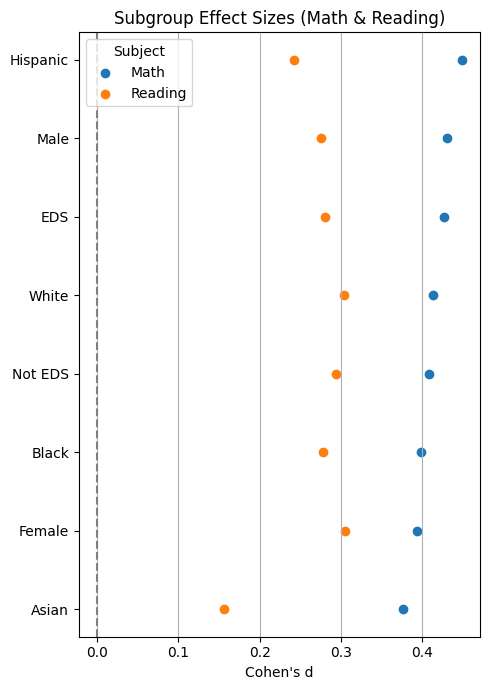

In [54]:
import matplotlib.pyplot as plt

# Step 1: Clean the labels as before
ethnic_labels = {'H': 'Hispanic', 'A': 'Asian', 'W': 'White', 'B': 'Black'}

def clean_label(row):
    if row['subgroup'] == 'sex_M':
        return 'Male' if row['subgroup_value'] else 'Female'
    elif row['subgroup'] == 'eds_Y':
        return 'EDS' if row['subgroup_value'] else 'Not EDS'
    elif row['subgroup'].startswith('ethnic_'):
        code = row['subgroup'].split('_')[1]
        return ethnic_labels.get(code) if row['subgroup_value'] else None
    return None

df = subgroup_df.reset_index()
df = df[['subgroup', 'subgroup_value', 'outcome', "Cohen's d"]].copy()
df['Group'] = df.apply(clean_label, axis=1)
df = df.dropna(subset=['Group'])
df['Subject'] = df['outcome'].map({'math_post': 'Math', 'reading_post': 'Reading'})

# Step 2: Pivot so each group is one row, with separate columns for math/reading
pivot_df = df.pivot(index='Group', columns='Subject', values="Cohen's d").reset_index()

# Step 3: Sort top-to-bottom
pivot_df = pivot_df.sort_values(by=['Math', 'Reading'], ascending=True)  # lowest at top

# Step 4: Plot
plt.figure(figsize=(5, 7))
y_pos = range(len(pivot_df))

plt.scatter(pivot_df['Math'], y_pos, color='tab:blue', label='Math')
plt.scatter(pivot_df['Reading'], y_pos, color='tab:orange', label='Reading')

plt.axvline(0, color='gray', linestyle='--')
plt.yticks(ticks=y_pos, labels=pivot_df['Group'])
plt.xlabel("Cohen's d")
plt.title("Subgroup Effect Sizes (Math & Reading)")
plt.legend(title='Subject',loc = 'upper left')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


Math is consistently more impacted by the gifted label even among subgroups. Boys, economically disadvantaged, and Hispanic (sample size?) and white students show the biggest impact. Asians, Native Americans, and Black students see the smallest effects in math and reading.

In [55]:
sat_scores = pd.read_csv("../data/sat.csv")
sats = all_matches.merge(sat_scores, on='mastid',how='left')
sats.dropna(inplace=True)
duplicate_counts = sats['match_id'].value_counts()
duplicates_only = duplicate_counts[duplicate_counts > 1]

sats = sats[sats['match_id'].isin(duplicates_only.index)]


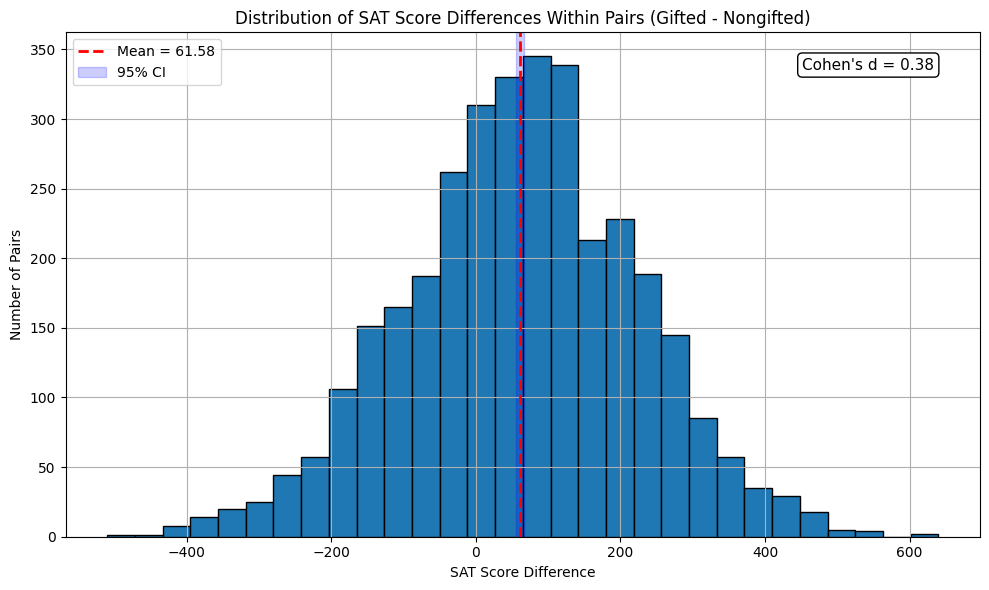

In [56]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Step 1: Sort so gifted comes first
pairs = sats.sort_values('gifted_grade', ascending=False)

# Step 2: Compute SAT score difference: gifted − non-gifted
diffs = pairs.groupby('match_id')['SAT_Total_Score_HC'].apply(
    lambda x: x.iloc[0] - x.iloc[1]
).reset_index(name='score_diff')

# Step 3: Drop any NaNs
sat_diff = diffs['score_diff'].dropna()

# Step 4: Compute stats
mean_diff = sat_diff.mean()
se_diff = stats.sem(sat_diff)
ci_lower, ci_upper = stats.t.interval(
    0.95, df=len(sat_diff) - 1, loc=mean_diff, scale=se_diff
)
cohen_d = mean_diff / sat_diff.std(ddof=1)

# Step 5: Plot
plt.figure(figsize=(10, 6))
plt.hist(sat_diff, bins=30, edgecolor='black')
plt.axvline(mean_diff, color='red', linestyle='dashed', linewidth=2, label=f'Mean = {mean_diff:.2f}')
plt.axvspan(ci_lower, ci_upper, color='blue', alpha=0.2, label='95% CI')

# Add Cohen's d text
plt.text(0.95, 0.95, f"Cohen's d = {cohen_d:.2f}", transform=plt.gca().transAxes,
         ha='right', va='top', fontsize=11,
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

# Final touches
plt.title('Distribution of SAT Score Differences Within Pairs (Gifted - Nongifted)')
plt.xlabel('SAT Score Difference')
plt.ylabel('Number of Pairs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [57]:
#SAT ate table
pairs = sats.sort_values('gifted_grade', ascending=False)

# Compute the SAT score difference: gifted - non-gifted
pairs['rank'] = pairs.groupby('match_id').cumcount()
gifted = pairs[pairs['rank'] == 0]
non_gifted = pairs[pairs['rank'] == 1]

# Merge gifted and non-gifted rows for each pair
merged = gifted[['match_id', 'gifted_grade', 'SAT_Total_Score_HC']].merge(
    non_gifted[['match_id', 'SAT_Total_Score_HC']],
    on='match_id',
    suffixes=('_gifted', '_nongifted')
)

# Compute score difference
merged['score_diff'] = merged['SAT_Total_Score_HC_gifted'] - merged['SAT_Total_Score_HC_nongifted']

# Group by gifted_grade and compute summary stats
summary = merged.groupby('gifted_grade')['score_diff'].agg(['count', 'mean', 'std']).reset_index()
summary.columns = ['gifted_grade', 'pair_count', 'avg_score_diff', 'std_dev']
from scipy.stats import ttest_rel

# Same setup from before to get merged gifted and non-gifted scores
pairs = sats.sort_values('gifted_grade', ascending=False)
pairs['rank'] = pairs.groupby('match_id').cumcount()
gifted = pairs[pairs['rank'] == 0]
non_gifted = pairs[pairs['rank'] == 1]

merged = gifted[['match_id', 'gifted_grade', 'SAT_Total_Score_HC']].merge(
    non_gifted[['match_id', 'SAT_Total_Score_HC']],
    on='match_id',
    suffixes=('_gifted', '_nongifted')
)

merged['score_diff'] = merged['SAT_Total_Score_HC_gifted'] - merged['SAT_Total_Score_HC_nongifted']

# Function to compute Cohen’s d and p-value per gifted_grade
def compute_effect_stats(df):
    x = df['SAT_Total_Score_HC_gifted']
    y = df['SAT_Total_Score_HC_nongifted']
    diff = x - y

    # Cohen’s d for paired samples
    d = diff.mean() / diff.std(ddof=1)
    
    # Paired t-test
    t_stat, p_val = ttest_rel(x, y)

    return pd.Series({
        'pair_count': len(df),
        'avg_score_diff': diff.mean(),
        'std_dev': diff.std(ddof=1),
        'cohens_d': d,
        'p_value': p_val
    })

# Apply per gifted_grade
summary = merged.groupby('gifted_grade').apply(compute_effect_stats).reset_index();
summary


/var/folders/dk/2mw0y5w91dggrsnrpxb04jv80000gn/T/ipykernel_14810/3748080586.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary = merged.groupby('gifted_grade').apply(compute_effect_stats).reset_index();


,gifted_grade,pair_count,avg_score_diff,std_dev,cohens_d,p_value
0,4,2441.0,78.189267,164.918008,0.474110,1.272547e-109
1,5,468.0,27.051282,146.389311,0.184790,7.434847e-05
2,6,271.0,9.557196,140.987875,0.067787,2.654482e-01
3,7,113.0,16.017699,140.385565,0.114098,2.277287e-01
4,8,82.0,-1.097561,144.290568,-0.007607,9.452543e-01


In [58]:
#SAT ate table by subject
from scipy.stats import ttest_rel
import pandas as pd

# Sort and assign ranks
pairs = sats.sort_values('gifted_grade', ascending=False)
pairs['rank'] = pairs.groupby('match_id').cumcount()

# Split gifted and non-gifted
gifted = pairs[pairs['rank'] == 0]
non_gifted = pairs[pairs['rank'] == 1]

# Merge based on match_id
merged = gifted[['match_id', 'gifted_grade', 'SAT_Math_Score_HC', 'SAT_EBRW_Score_HC']].merge(
    non_gifted[['match_id', 'SAT_Math_Score_HC', 'SAT_EBRW_Score_HC']],
    on='match_id',
    suffixes=('_gifted', '_nongifted')
)

# Calculate differences
merged['math_diff'] = merged['SAT_Math_Score_HC_gifted'] - merged['SAT_Math_Score_HC_nongifted']
merged['reading_diff'] = merged['SAT_EBRW_Score_HC_gifted'] - merged['SAT_EBRW_Score_HC_nongifted']

# Function to compute stats per gifted_grade
def compute_diff_stats(df, col_gifted, col_nongifted, diff_name):
    x = df[col_gifted]
    y = df[col_nongifted]
    diff = x - y

    return pd.Series({
        f'{diff_name}_pair_count': len(df),
        f'{diff_name}_avg_diff': diff.mean(),
        f'{diff_name}_std_dev': diff.std(ddof=1),
        f'{diff_name}_cohens_d': diff.mean() / diff.std(ddof=1),
        f'{diff_name}_p_value': ttest_rel(x, y).pvalue
    })

# Apply stats computation grouped by gifted_grade
math_stats = merged.groupby('gifted_grade').apply(
    lambda df: compute_diff_stats(df, 'SAT_Math_Score_HC_gifted', 'SAT_Math_Score_HC_nongifted', 'math')
).reset_index()

reading_stats = merged.groupby('gifted_grade').apply(
    lambda df: compute_diff_stats(df, 'SAT_EBRW_Score_HC_gifted', 'SAT_EBRW_Score_HC_nongifted', 'reading')
).reset_index()

# Merge both into a combined summary table
summary = math_stats.merge(reading_stats, on='gifted_grade')
summary




/var/folders/dk/2mw0y5w91dggrsnrpxb04jv80000gn/T/ipykernel_14810/2719171939.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  math_stats = merged.groupby('gifted_grade').apply(
/var/folders/dk/2mw0y5w91dggrsnrpxb04jv80000gn/T/ipykernel_14810/2719171939.py:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  reading_stats = merged.groupby('gifted_grade').apply(


,gifted_grade,math_pair_count,math_avg_diff,math_std_dev,math_cohens_d,math_p_value,reading_pair_count,reading_avg_diff,reading_std_dev,reading_cohens_d,reading_p_value
0,4,2441.0,41.208521,92.896326,0.443597,2.437063e-97,2441.0,36.980746,90.693250,0.407756,1.277529e-83
1,5,468.0,15.042735,88.647935,0.169691,2.695319e-04,468.0,12.008547,77.397608,0.155154,8.538264e-04
2,6,271.0,4.612546,81.434689,0.056641,3.519477e-01,271.0,4.944649,79.423249,0.062257,3.063377e-01
3,7,113.0,8.938053,85.224104,0.104877,2.672977e-01,113.0,7.079646,77.051483,0.091882,3.308131e-01
4,8,82.0,4.634146,83.150839,0.055732,6.151588e-01,82.0,-5.731707,77.714744,-0.073753,5.061194e-01


It's interesting that there's a bigger long term effect for standardized test reading scores, but SAT math scores increase more/similarly to SAT reading scores

In [59]:
gpa = pd.read_csv("../data/gpa_master.csv")
gpa = gpa[['mastid','gpa_unweighted','gpa_weighted','bound_for']]
gpa_matches = all_matches_trimmed.merge(gpa,on='mastid',how='left')

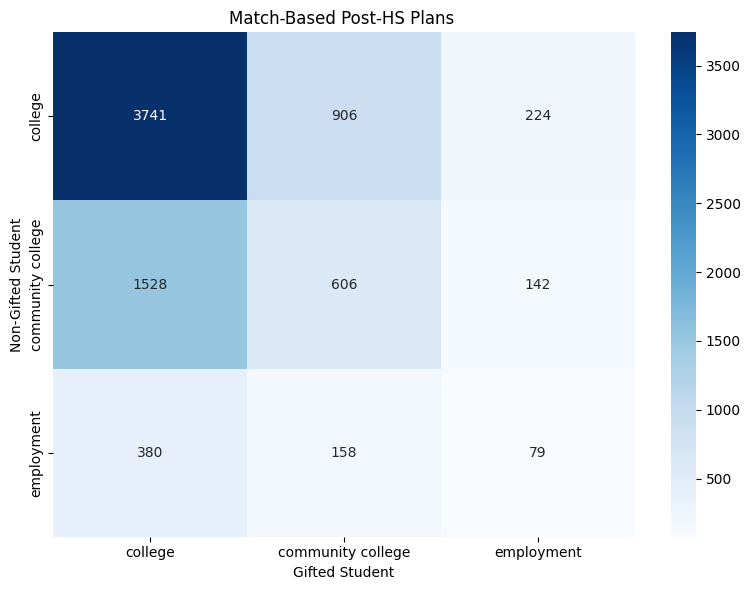

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Recode bound_for labels
def recode_bound_for(val):
    if pd.isna(val):
        return val
    val_lower = val.lower()
    if "institution" in val_lower:
        return "college"
    elif "tech" in val_lower:
        return "community college"
    elif "employment" in val_lower:
        return "employment"
    else:
        return None  # filter out all other categories

gpa_matches['bound_for'] = gpa_matches['bound_for'].apply(recode_bound_for)

# Step 2: Pivot into matched pairs
pairs = gpa_matches.pivot(index='match_id', columns='treatment', values='bound_for').dropna()
pairs.columns = ['non_gifted_bound_for', 'gifted_bound_for']

# Step 3: Filter to only the three target categories
valid_categories = ['college', 'community college', 'employment']
pairs = pairs[
    pairs['non_gifted_bound_for'].isin(valid_categories) &
    pairs['gifted_bound_for'].isin(valid_categories)
]

# Step 4: Count unique pairings
pair_counts = pairs.value_counts().reset_index(name='count')

# Step 5: Create pivot table
pivot_table = pair_counts.pivot(
    index='non_gifted_bound_for',
    columns='gifted_bound_for',
    values='count'
).fillna(0)

# Step 6: Filter to rows with any value > 100
pivot_table = pivot_table[pivot_table.gt(100).any(axis=1)]

# Step 7: Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap="Blues")
plt.title("Match-Based Post-HS Plans ")
plt.xlabel("Gifted Student")
plt.ylabel("Non-Gifted Student")
plt.tight_layout()
plt.show()


In [61]:
# Identify match_ids where any row has a NaN
bad_match_ids = gpa_matches[gpa_matches.isna().any(axis=1)]['match_id'].unique()

# Drop all rows with those match_ids
gpa_matches = gpa_matches[~gpa_matches['match_id'].isin(bad_match_ids)]


In [62]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Step 1: Sort to ensure gifted comes first
gpa_matches = gpa_matches.sort_values('gifted_grade', ascending=False)
gpa_matches['rank'] = gpa_matches.groupby('match_id').cumcount()

# Step 2: Separate gifted and non-gifted
gifted = gpa_matches[gpa_matches['rank'] == 0]
non_gifted = gpa_matches[gpa_matches['rank'] == 1]

# Step 3a: Weighted GPA difference
merged_weighted = gifted[['match_id', 'gpa_weighted']].merge(
    non_gifted[['match_id', 'gpa_weighted']],
    on='match_id',
    suffixes=('_gifted', '_nongifted')
)
merged_weighted['gpa_diff'] = merged_weighted['gpa_weighted_gifted'] - merged_weighted['gpa_weighted_nongifted']
weighted_diff = merged_weighted['gpa_diff'].dropna()
mean_weighted = weighted_diff.mean()
se_weighted = stats.sem(weighted_diff)
ci_weighted = stats.t.interval(0.95, df=len(weighted_diff) - 1, loc=mean_weighted, scale=se_weighted)
cohen_d_weighted = mean_weighted / weighted_diff.std(ddof=1)

# Step 3b: Unweighted GPA difference
merged_unweighted = gifted[['match_id', 'gpa_unweighted']].merge(
    non_gifted[['match_id', 'gpa_unweighted']],
    on='match_id',
    suffixes=('_gifted', '_nongifted')
)
merged_unweighted['gpa_diff'] = merged_unweighted['gpa_unweighted_gifted'] - merged_unweighted['gpa_unweighted_nongifted']
unweighted_diff = merged_unweighted['gpa_diff'].dropna()
mean_unweighted = unweighted_diff.mean()
se_unweighted = stats.sem(unweighted_diff)
ci_unweighted = stats.t.interval(0.95, df=len(unweighted_diff) - 1, loc=mean_unweighted, scale=se_unweighted)
cohen_d_unweighted = mean_unweighted / unweighted_diff.std(ddof=1)

# Step 4: Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Weighted GPA plot
axes[0].hist(weighted_diff, bins=50, edgecolor='black')
axes[0].axvline(mean_weighted, color='red', linestyle='dashed', linewidth=2, label=f'Mean = {mean_weighted:.3f}')
axes[0].axvspan(ci_weighted[0], ci_weighted[1], color='blue', alpha=0.2, label='95% CI')
axes[0].set_title('Weighted GPA Differences (Gifted - Non-Gifted)')
axes[0].set_xlabel('GPA Difference')
axes[0].set_ylabel('Number of Pairs')
axes[0].grid(True)
axes[0].legend()
axes[0].text(0.95, 0.95, f"Cohen's d = {cohen_d_weighted:.2f}",
             transform=axes[0].transAxes, ha='right', va='top', fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

# Unweighted GPA plot
axes[1].hist(unweighted_diff, bins=50, edgecolor='black')
axes[1].axvline(mean_unweighted, color='red', linestyle='dashed', linewidth=2, label=f'Mean = {mean_unweighted:.3f}')
axes[1].axvspan(ci_unweighted[0], ci_unweighted[1], color='blue', alpha=0.2, label='95% CI')
axes[1].set_title('Unweighted GPA Differences (Gifted - Non-Gifted)')
axes[1].set_xlabel('GPA Difference')
axes[1].grid(True)
axes[1].legend()
axes[1].text(0.95, 0.95, f"Cohen's d = {cohen_d_unweighted:.2f}",
             transform=axes[1].transAxes, ha='right', va='top', fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

plt.tight_layout()
plt.show()


In [63]:
#gpa ate table
from scipy.stats import ttest_rel

# Step 1: Ensure gifted student is first
gpa_matches = gpa_matches.sort_values('gifted_grade', ascending=False)
gpa_matches['rank'] = gpa_matches.groupby('match_id').cumcount()

# Step 2: Separate gifted and non-gifted
gifted = gpa_matches[gpa_matches['rank'] == 0]
non_gifted = gpa_matches[gpa_matches['rank'] == 1]

# Step 3: Merge weighted and unweighted GPAs
merged = gifted[['match_id', 'gpa_weighted', 'gpa_unweighted']].merge(
    non_gifted[['match_id', 'gpa_weighted', 'gpa_unweighted']],
    on='match_id',
    suffixes=('_gifted', '_nongifted')
)

# Step 4: Compute differences
merged['gpa_weighted_diff'] = merged['gpa_weighted_gifted'] - merged['gpa_weighted_nongifted']
merged['gpa_unweighted_diff'] = merged['gpa_unweighted_gifted'] - merged['gpa_unweighted_nongifted']

# Step 5: Define a function for stats
def compute_stats(diff_series):
    ate = diff_series.mean()
    std_dev = diff_series.std(ddof=1)
    d = ate / std_dev if std_dev != 0 else np.nan
    _, pval = ttest_rel(merged[diff_series.name.replace('_diff', '_gifted')],
                        merged[diff_series.name.replace('_diff', '_nongifted')])
    return ate, std_dev, d, pval

# Step 6: Apply to both GPA types
results = {
    'Metric': [],
    'ATE': [],
    'Std Dev': [],
    'Cohen\'s d': [],
    'p-value': []
}

for col in ['gpa_weighted_diff', 'gpa_unweighted_diff']:
    ate, std_dev, d, pval = compute_stats(merged[col])
    results['Metric'].append(col)
    results['ATE'].append(ate)
    results['Std Dev'].append(std_dev)
    results['Cohen\'s d'].append(d)
    results['p-value'].append(pval)

summary_df = pd.DataFrame(results)
summary_df

,Metric,ATE,Std Dev,Cohen's d,p-value
0,gpa_weighted_diff,0.228461,0.825979,0.276594,1.761946e-126
1,gpa_unweighted_diff,0.155147,0.690333,0.224742,3.477245e-85


In [64]:
act_scores = pd.read_csv("../data/act.csv")
acts = all_matches.merge(act_scores, on='mastid',how='left')
acts.dropna(inplace=True)
duplicate_counts = acts['match_id'].value_counts()
duplicates_only = duplicate_counts[duplicate_counts > 1]

acts = acts[acts['match_id'].isin(duplicates_only.index)]


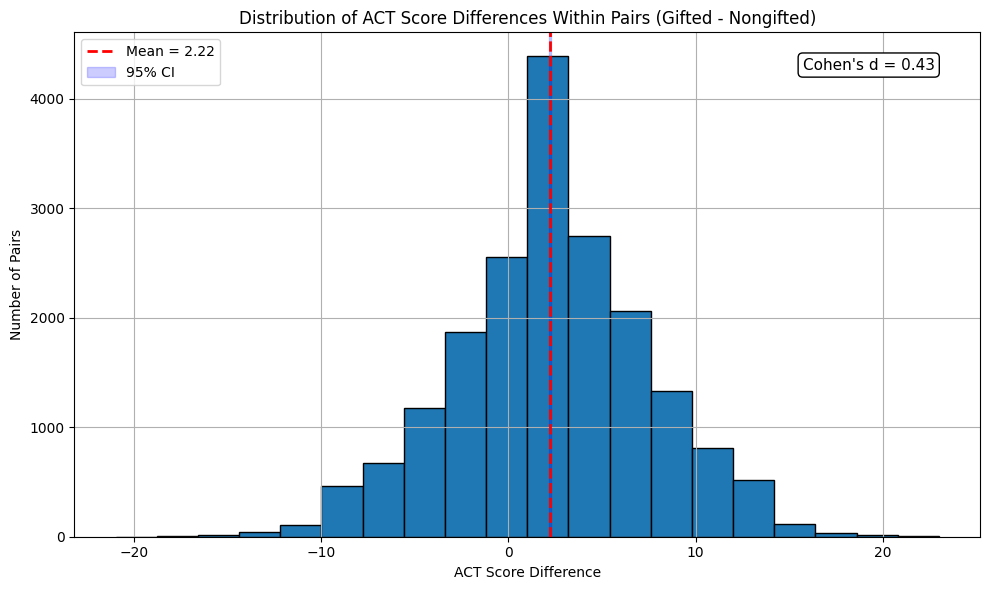

In [70]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Step 1: Filter to test_id == 'ACCO'
acts_acco = acts[acts['test_id'] == 'ACCO'].copy()

# Step 2: Keep only match_ids that appear exactly twice (valid pairs)
valid_pairs = acts_acco['match_id'].value_counts()
valid_pairs = valid_pairs[valid_pairs == 2].index
acts_acco = acts_acco[acts_acco['match_id'].isin(valid_pairs)]

# Step 3: Sort so gifted comes first
pairs = acts_acco.sort_values('gifted_grade', ascending=False)

# Step 4: Compute ACT score difference: gifted − non-gifted
diffs = pairs.groupby('match_id')['score'].apply(lambda x: x.iloc[0] - x.iloc[1]).reset_index(name='act_score_diff')

# Drop any NaNs just in case
act_diff = diffs['act_score_diff'].dropna()

# Compute stats
mean_diff = act_diff.mean()
se_diff = stats.sem(act_diff)
ci_lower, ci_upper = stats.t.interval(0.95, df=len(act_diff) - 1, loc=mean_diff, scale=se_diff)
cohen_d = mean_diff / act_diff.std(ddof=1)

# Step 5: Plot
plt.figure(figsize=(10, 6))
plt.hist(act_diff, bins=20, edgecolor='black')
plt.axvline(mean_diff, color='red', linestyle='dashed', linewidth=2, label=f'Mean = {mean_diff:.2f}')
plt.axvspan(ci_lower, ci_upper, color='blue', alpha=0.2, label='95% CI')

# Add Cohen's d as text
plt.text(0.95, 0.95, f"Cohen's d = {cohen_d:.2f}", transform=plt.gca().transAxes,
         ha='right', va='top', fontsize=11,
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

# Labels and title
plt.title('Distribution of ACT Score Differences Within Pairs (Gifted - Nongifted)')
plt.xlabel('ACT Score Difference')
plt.ylabel('Number of Pairs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [66]:
# # List of test_ids to plot
# test_ids = ['ACMA', 'ACRD', 'ACEN', 'ACSC']

# for test in test_ids:
#     # Step 1: Filter to current test_id
#     subset = acts[acts['test_id'] == test].copy()
    
#     # Step 2: Keep only valid matched pairs (match_id appears exactly twice)
#     valid_pairs = subset['match_id'].value_counts()
#     valid_pairs = valid_pairs[valid_pairs == 2].index
#     subset = subset[subset['match_id'].isin(valid_pairs)]
    
#     # Step 3: Sort so gifted comes first in each pair
#     pairs = subset.sort_values('gifted_grade', ascending=False)
    
#     # Step 4: Compute score difference (gifted - nongifted)
#     diffs = pairs.groupby('match_id')['score'].apply(lambda x: x.iloc[0] - x.iloc[1]).reset_index(name='score_diff')
    
#     # Step 5: Plot the differences
#     plt.figure(figsize=(10, 6))
#     plt.hist(diffs['score_diff'], bins=20, edgecolor='black')
#     plt.title(f'Distribution of ACT {test} Score Differences Within Pairs (Gifted - Nongifted)')
#     plt.xlabel(f'{test} Score Difference')
#     plt.ylabel('Number of Pairs')
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()


In [67]:
from scipy.stats import ttest_rel
import pandas as pd

def compute_act_summary(acts, test_id):
    df = acts[(acts['test_id'] == test_id)].copy()

    # Keep only valid matched pairs
    valid_pairs = df['match_id'].value_counts()
    valid_pairs = valid_pairs[valid_pairs == 2].index
    df = df[df['match_id'].isin(valid_pairs)]

    # Sort so gifted comes first
    df = df.sort_values('gifted_grade', ascending=False)
    df['rank'] = df.groupby('match_id').cumcount()

    gifted = df[df['rank'] == 0]
    non_gifted = df[df['rank'] == 1]

    merged = gifted[['match_id', 'gifted_grade', 'score']].merge(
        non_gifted[['match_id', 'score']],
        on='match_id',
        suffixes=('_gifted', '_nongifted')
    )

    def compute_effect_stats(group):
        x = group['score_gifted']
        y = group['score_nongifted']
        diff = x - y
        return pd.Series({
            'pair_count': len(group),
            'avg_score_diff': diff.mean(),
            'std_dev': diff.std(ddof=1),
            'cohens_d': diff.mean() / diff.std(ddof=1),
            'p_value': ttest_rel(x, y).pvalue
        })

    summary = merged.groupby('gifted_grade').apply(compute_effect_stats).reset_index()
    summary['test_id'] = test_id
    return summary

# Run this with your `acts` DataFrame
test_ids = ['ACCO', 'ACMA', 'ACRD', 'ACEN', 'ACSC']
all_summaries = pd.concat([compute_act_summary(acts, tid) for tid in test_ids], ignore_index=True)

all_summaries = all_summaries[all_summaries['gifted_grade'] == 4]
all_summaries

/var/folders/dk/2mw0y5w91dggrsnrpxb04jv80000gn/T/ipykernel_14810/2339316588.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary = merged.groupby('gifted_grade').apply(compute_effect_stats).reset_index()
/var/folders/dk/2mw0y5w91dggrsnrpxb04jv80000gn/T/ipykernel_14810/2339316588.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary = merged.groupby('gifted_grade').apply(compute_effect_stats).

,gifted_grade,pair_count,avg_score_diff,std_dev,cohens_d,p_value,test_id
1,4,12468.0,2.759865,5.298161,0.520910,0.0,ACCO
7,4,12487.0,2.579002,5.469249,0.471546,0.0,ACMA
13,4,12471.0,3.048432,7.356359,0.414394,0.0,ACRD
19,4,12490.0,2.882866,6.699417,0.430316,0.0,ACEN
25,4,12468.0,2.521094,5.892376,0.427857,0.0,ACSC


In [68]:
#all_matches_trimmed.to_csv("../../data/processed/finalpairs.csv")

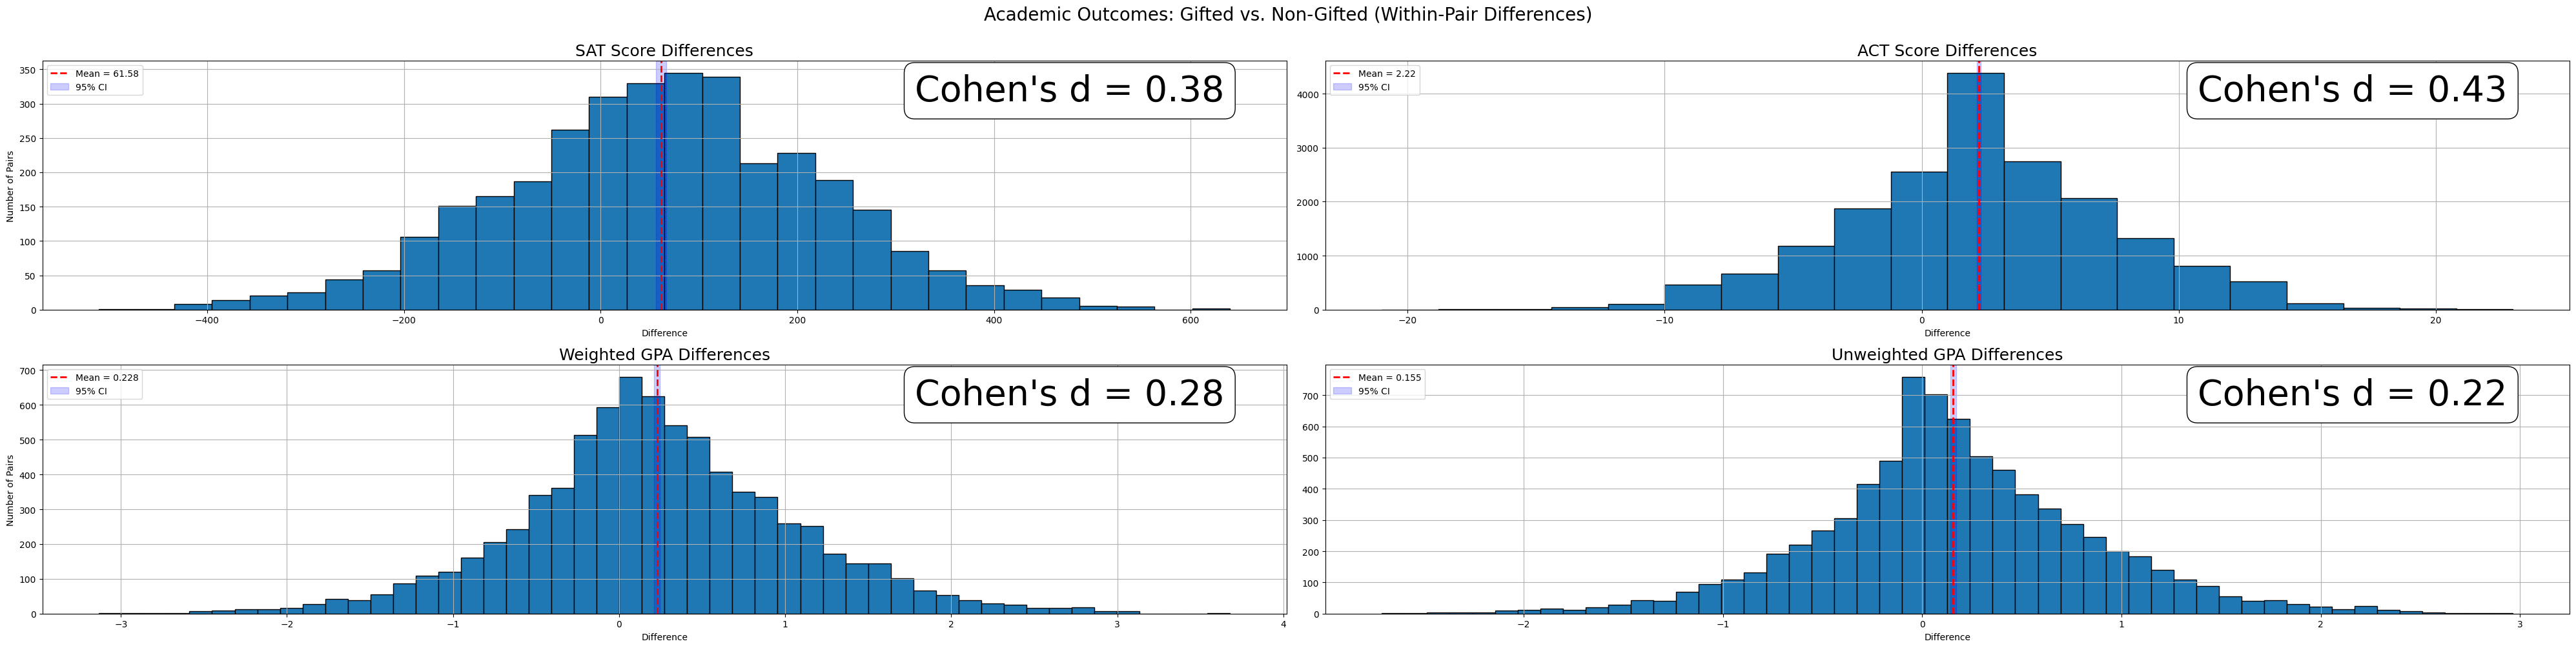

In [69]:
import matplotlib.pyplot as plt
from scipy import stats

fig, axes = plt.subplots(2, 2, figsize=(40, 10))  # 2 rows, 2 cols

mean_sat = sat_diff.mean()
se_sat = stats.sem(sat_diff)
ci_sat_lower, ci_sat_upper = stats.t.interval(0.95, df=len(sat_diff) - 1, loc=mean_sat, scale=se_sat)
cohen_d_sat = mean_sat / sat_diff.std(ddof=1)

# === SAT Plot ===
sat_ax = axes[0, 0]
sat_ax.hist(sat_diff, bins=30, edgecolor='black')
sat_ax.axvline(mean_sat, color='red', linestyle='dashed', linewidth=2, label=f'Mean = {mean_sat:.2f}')
sat_ax.axvspan(ci_sat_lower, ci_sat_upper, color='blue', alpha=0.2, label='95% CI')
sat_ax.set_title('SAT Score Differences')
sat_ax.set_xlabel('Difference')
sat_ax.set_ylabel('Number of Pairs')
sat_ax.grid(True)
sat_ax.legend()
sat_ax.text(0.95, 0.95, f"Cohen\'s d = {cohen_d_sat:.2f}", transform=sat_ax.transAxes,
            ha='right', va='top', fontsize=40,
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

# === ACT Plot ===
# Compute ACT-specific stats (if not already done)
mean_act = act_diff.mean()
se_act = stats.sem(act_diff)
ci_act_lower, ci_act_upper = stats.t.interval(0.95, df=len(act_diff) - 1, loc=mean_act, scale=se_act)
cohen_d_act = mean_act / act_diff.std(ddof=1)

# === ACT Plot ===
act_ax = axes[0, 1]
act_ax.hist(act_diff, bins=20, edgecolor='black')
act_ax.axvline(mean_act, color='red', linestyle='dashed', linewidth=2, label=f'Mean = {mean_act:.2f}')
act_ax.axvspan(ci_act_lower, ci_act_upper, color='blue', alpha=0.2, label='95% CI')
act_ax.set_title('ACT Score Differences')
act_ax.set_xlabel('Difference')
act_ax.grid(True)
act_ax.legend()
act_ax.text(0.95, 0.95, f"Cohen\'s d = {cohen_d_act:.2f}", transform=act_ax.transAxes,
            ha='right', va='top', fontsize=40,
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

# === Weighted GPA Plot ===
gpa_weight_ax = axes[1, 0]
gpa_weight_ax.hist(weighted_diff, bins=50, edgecolor='black')
gpa_weight_ax.axvline(mean_weighted, color='red', linestyle='dashed', linewidth=2, label=f'Mean = {mean_weighted:.3f}')
gpa_weight_ax.axvspan(ci_weighted[0], ci_weighted[1], color='blue', alpha=0.2, label='95% CI')
gpa_weight_ax.set_title('Weighted GPA Differences')
gpa_weight_ax.set_xlabel('Difference')
gpa_weight_ax.set_ylabel('Number of Pairs')
gpa_weight_ax.grid(True)
gpa_weight_ax.legend()
gpa_weight_ax.text(0.95, 0.95, f"Cohen\'s d = {cohen_d_weighted:.2f}", transform=gpa_weight_ax.transAxes,
                   ha='right', va='top', fontsize=40, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

# === Unweighted GPA Plot ===
gpa_unweight_ax = axes[1, 1]
gpa_unweight_ax.hist(unweighted_diff, bins=50, edgecolor='black')
gpa_unweight_ax.axvline(mean_unweighted, color='red', linestyle='dashed', linewidth=2, label=f'Mean = {mean_unweighted:.3f}')
gpa_unweight_ax.axvspan(ci_unweighted[0], ci_unweighted[1], color='blue', alpha=0.2, label='95% CI')
gpa_unweight_ax.set_title('Unweighted GPA Differences')
gpa_unweight_ax.set_xlabel('Difference')
gpa_unweight_ax.grid(True)
gpa_unweight_ax.legend()
gpa_unweight_ax.text(0.95, 0.95, f"Cohen\'s d = {cohen_d_unweighted:.2f}", transform=gpa_unweight_ax.transAxes,
                     ha='right', va='top', fontsize=40, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

sat_ax.set_title('SAT Score Differences', fontsize=18)
act_ax.set_title('ACT Score Differences', fontsize=18)
gpa_weight_ax.set_title('Weighted GPA Differences', fontsize=18)
gpa_unweight_ax.set_title('Unweighted GPA Differences', fontsize=18)

plt.suptitle("Academic Outcomes: Gifted vs. Non-Gifted (Within-Pair Differences)", fontsize=20, y=1.0)
plt.tight_layout()
plt.show()
